In [282]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.plotly as py
import json
plotly_key = json.load(open("/home/ubuntu/.api/plotly.api"))
py.sign_in('Crystal.Humphries', str(plotly_key['KEY']))

In [1]:
import graphlab as gl
gl.canvas.set_target('ipynb')
import matplotlib.pyplot as plt
from PodcastFeatureEngineering import Podcast_Features
%matplotlib inline
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import imp
import os
from collections import Counter
import plotly.plotly as py
import json
plotly_key = json.load(open("/home/ubuntu/.api/plotly.api"))
py.sign_in('Crystal.Humphries', str(plotly_key['KEY']))

2016-04-21 22:27:06,280 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1461277625.log


This non-commercial license of GraphLab Create is assigned to crystal.humphries@systemsbiology.org and will expire on November 04, 2016. For commercial licensing options, visit https://dato.com/buy/.


In [2]:
loc = os.path.join('/home/ubuntu/PodcastRecommender/', "src/twitter_followers_list.py")
tweets = imp.load_source('get_twitter_followers', loc)
tweets = tweets.get_twitter_followers()
tweets.get_overlapping_users(Num=3)
item_sim_mat = tweets.Item_sim_matrix(max_num=20000)

In [3]:
sf = gl.SFrame(item_sim_mat)

In [4]:
(train_set, test_set) = sf.random_split(0.8, seed=1)

# Feature Engineering MetaData

In [5]:
PF = Podcast_Features()
df = PF.cleaned_df

/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: DtypeWarning: Columns (14,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
clean_podcast_csv.py:24: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  self.df['DateFirstEpisode'] = self.df.DateFirstEpisode.apply(lambda x: pd.to_datetime(str(x), coerce=True))


Creating Tf-idf


clean_podcast_csv.py:25: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  self.df['DateLastEpisode']  = self.df.DateLastEpisode.apply(lambda x: pd.to_datetime(str(x), coerce=True))


In [6]:
def get_top_100(col, df):
    tfidf = TfidfVectorizer( max_features=100, stop_words='english')
    X = tfidf.fit_transform(df[col])
    return pd.DataFrame(X.toarray(),
                        columns=pd.Series(tfidf.get_feature_names()))

def remove_bots(sf, flag=True):
    tr = pd.Series(sf['user_id'])
    podcasts = tr.value_counts()
    if flag is True:
        podcasts.hist(bins=200)
    users_following100_lessPods = gl.SArray(podcasts.index[ podcasts <= 100].values)
    return sf.filter_by(users_following100_lessPods, 'user_id')

In [92]:
df_orig = df.copy()
df = df.drop_duplicates()

In [93]:
g = df.columns.to_series().groupby(df.dtypes).groups
c = g.keys()
df2 = df.drop(g[c[0]], axis=1)
df2 = df2.drop(g[c[1]], axis=1)

In [96]:
dates=[]
for a,b in  zip(df.DateLastEpisode, df.DateFirstEpisode):
    try:
        new = (a-b).days
    except:
        new = 'NaT'
    dates.append(new)
dates = np.array(dates)

In [97]:
df2['Title'] = df.Title
df2['dates'] = dates

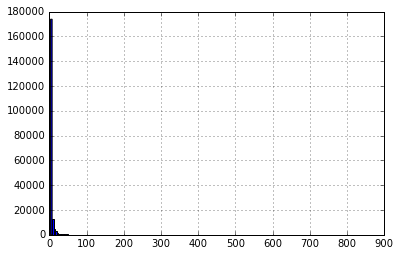

In [99]:
sf2 = remove_bots(sf)

In [98]:
unique_pod = item_sim_mat.Title.unique()
df_reduced = df2[ df2.Title.isin(unique_pod)]
items_reduced = gl.SFrame(df_reduced)
items = gl.SFrame(df2)
items_reduced.shape, items.shape

((29543, 6), (153679, 6))

# Create a table

In [41]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF

In [43]:
a = pd.DataFrame(df.dtypes)
#table = FF.create_table(a)
#py.iplot(table, filename='podcast_meta_dtypes')

In [50]:
a['Title'] = a.index
a.columns = ['DataTypes', 'Title']
a['DataTypes'] = a.DataTypes.apply(lambda x: "str" if x=="object" else x)

In [58]:
a = a[['Title', 'DataTypes']]

In [63]:
df_table[~df_table.Title.isin(['Link', 'ImageUrl', 'NormalizedUrl', 'iTunesOwnerEmail', 'iTunesOwnerName','iTunesAuthor', 'Title'])]

,Title,DataTypes
DateFirstEpisode,DateFirstEpisode,datetime64[ns]
DateLastEpisode,DateLastEpisode,datetime64[ns]
RatingCount,RatingCount,int64
TotalEpisodes,TotalEpisodes,int64
CategoryRanking,CategoryRanking,int64
AverageRating,AverageRating,float64
Category,Category,str
iTunesKeywords,iTunesKeywords,str
iTunesSummary,iTunesSummary,str
HostingDomain,HostingDomain,str


In [110]:
len(df.RatingCount[df.RatingCount>100])

2322

In [147]:
a =df.RatingCount[ (df.RatingCount<100) | (df.RatingCount>0)]

In [180]:
fig2 = plt.figure()
plt.hist(a, bins=1000)
plt.xlim(0,100)
plt.ylabel("Podcasts")
plt.title("90 of Podcasts have <100 Ratings")
plt.xlabel("# of Ratings")
py.iplot_mpl(fig2, strip_style = True,filename='Ratings Counts')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/plotly/matplotlylib/renderer.py:516: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



In [77]:
ti = df.Title.apply(lambda x: x.lower())

In [64]:
df_table = a.sort_values('DataTypes', ascending=True)
df_table = df_table[~df_table.Title.isin(['Link', 'ImageUrl', 'NormalizedUrl', 'iTunesOwnerEmail', 'iTunesOwnerName','iTunesAuthor', 'Title'])]
table = FF.create_table(df_table)
py.iplot(table, filename='podcast_meta_dtypes')

In [14]:
(train_set_2, test_set_2) = sf2.random_split(0.8, seed=1)

In [100]:
# run with trainset2<-no bots and items<-all meta data no filter
item_model = gl.item_similarity_recommender.create(train_set_2, user_id="user_id", 
                                                   item_id="Title", item_data=items, verbose=False)
item_model.evaluate_precision_recall(test_set_2, cutoffs=[1,2,3,4,5], verbose=False)

Recsys training: model = item_similarity

{'precision_recall_by_user': Columns:
 	user_id	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 602930
 
 Data:
 +---------+--------+----------------+--------+-------+
 | user_id | cutoff |   precision    | recall | count |
 +---------+--------+----------------+--------+-------+
 |  user_0 |   1    |      1.0       |  1.0   |   1   |
 |  user_0 |   2    |      0.5       |  1.0   |   1   |
 |  user_0 |   3    | 0.333333333333 |  1.0   |   1   |
 |  user_0 |   4    |      0.25      |  1.0   |   1   |
 |  user_0 |   5    |      0.2       |  1.0   |   1   |
 | user_10 |   1    |      0.0       |  0.0   |   1   |
 | user_10 |   2    |      0.0       |  0.0   |   1   |
 | user_10 |   3    |      0.0       |  0.0   |   1   |
 | user_10 |   4    |      0.0       |  0.0   |   1   |
 | user_10 |   5    |      0.2       |  1.0   |   1   |
 +---------+--------+----------------+--------+-------+
 [602930 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You ca

In [101]:
# run with trainset2<-no bots and items<-meta data with podcasts only seen by users
item_model = gl.item_similarity_recommender.create(train_set_2, user_id="user_id", 
                                                   item_id="Title", item_data=items_reduced, verbose=False)
item_model.evaluate_precision_recall(test_set_2, cutoffs=[1,2,3,4,5], verbose=False)

Recsys training: model = item_similarity

{'precision_recall_by_user': Columns:
 	user_id	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 602930
 
 Data:
 +---------+--------+----------------+--------+-------+
 | user_id | cutoff |   precision    | recall | count |
 +---------+--------+----------------+--------+-------+
 |  user_0 |   1    |      1.0       |  1.0   |   1   |
 |  user_0 |   2    |      0.5       |  1.0   |   1   |
 |  user_0 |   3    | 0.333333333333 |  1.0   |   1   |
 |  user_0 |   4    |      0.25      |  1.0   |   1   |
 |  user_0 |   5    |      0.2       |  1.0   |   1   |
 | user_10 |   1    |      0.0       |  0.0   |   1   |
 | user_10 |   2    |      0.0       |  0.0   |   1   |
 | user_10 |   3    |      0.0       |  0.0   |   1   |
 | user_10 |   4    |      0.0       |  0.0   |   1   |
 | user_10 |   5    |      0.2       |  1.0   |   1   |
 +---------+--------+----------------+--------+-------+
 [602930 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You ca

In [182]:
all_categories = df.Category.apply(lambda x: x.split('/'))
temp = [item for sublist in all_categories for item in sublist]
categories = {x:0 for x in temp}

cats = pd.DataFrame(0, index=np.arange(len(df.Category.values)), columns=categories.keys())
for i,v in enumerate(df.Category.values):
    ls = v.split('/')
    cats.loc[i][ls] = 1
cats.head()

,Performing Arts,Philosophy,Tech News,Fitness & Nutrition,Podcasting,Games & Hobbies,Science & Medicine,Educational Technology,Arts,Sports & Recreation,...,Gadgets,Literary Criticism,Design,Teaching & Learning,Hobbies,Music,Management,Education,Technology,Islam
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [251]:
cats.index = df.index

In [252]:
df.shape, cats.shape
cats.index = df.index
d = pd.concat([df, cats], axis=1)
d.shape

(153679, 97)

In [253]:
g = d.columns.to_series().groupby(d.dtypes).groups
c = g.keys()
df2 = d.drop(g[c[0]], axis=1)
df2 = df2.drop(g[c[1]], axis=1)

In [254]:
df2['Title'] = df.Title
d = pd.concat([df2, cats], axis=1)
d['Title'] = d.Title.astype('str')

In [263]:
d_clean = remove_duplicate_columns(d)
df_raw_cl = gl.SFrame(d_clean)

In [267]:
# run with trainset2<-no bots and items<-meta data plus categories
item_model = gl.item_similarity_recommender.create(train_set_2, user_id="user_id", 
                                                   item_id="Title", item_data=df_raw_cl, verbose=False)
item_model.evaluate_precision_recall(test_set_2, cutoffs=[1,2,3,4,5], verbose=False)

Recsys training: model = item_similarity

{'precision_recall_by_user': Columns:
 	user_id	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 602930
 
 Data:
 +---------+--------+----------------+--------+-------+
 | user_id | cutoff |   precision    | recall | count |
 +---------+--------+----------------+--------+-------+
 |  user_0 |   1    |      1.0       |  1.0   |   1   |
 |  user_0 |   2    |      0.5       |  1.0   |   1   |
 |  user_0 |   3    | 0.333333333333 |  1.0   |   1   |
 |  user_0 |   4    |      0.25      |  1.0   |   1   |
 |  user_0 |   5    |      0.2       |  1.0   |   1   |
 | user_10 |   1    |      0.0       |  0.0   |   1   |
 | user_10 |   2    |      0.0       |  0.0   |   1   |
 | user_10 |   3    |      0.0       |  0.0   |   1   |
 | user_10 |   4    |      0.0       |  0.0   |   1   |
 | user_10 |   5    |      0.2       |  1.0   |   1   |
 +---------+--------+----------------+--------+-------+
 [602930 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You ca

In [279]:
orig_results = results['precision_recall_overall']

In [280]:
orig_results

cutoff,precision,recall
1,0.409400759624,0.296500446387
2,0.272005042045,0.355705003744
3,0.201897401025,0.378786165323
4,0.161051034117,0.3923757844
5,0.134382100741,0.402558431288


In [261]:
##cleaning the mess up
def remove_duplicate_columns(df):
    ls = Counter(df.columns)
    df_final = pd.DataFrame()
    for a,b in ls.items():
        if b==1:
            df_final = pd.concat([df_final, df[a]],axis=1)
        else:
            df_final[a] = df[[a]].sum(axis=1)
    return df_final

In [411]:
df3 = d.copy()

dates=[]
for a,b in  zip(df.DateLastEpisode, df.DateFirstEpisode):
    try:
        new = (a-b).days
    except:
        new = -1
    dates.append(new)
    
df3['dates'] = np.array(dates)

df3['dates'] = df3['dates'].astype('int')
for col in ['iTunesSummary', 'iTunesKeywords','Category','iTunesSubtitle', 'HostingDomain']:
    y = get_top_100(col, df)
    df3 = pd.concat([df3, y], axis=1)

In [ ]:
# cols = df3.columns.str.lower()
# df3.columns  = cols

In [412]:
df_cat_tfidf_orig = remove_duplicate_columns(df3)

In [417]:
df_cat_tfidf_orig['Title'] = d.Title
#df_cat_tfidf_orig.drop("title", axis=1, inplace=True)
df_cat_tfidf_orig['Title'] = df_cat_tfidf_orig.Title.astype('str')
gl_cat_tfidf_temp = gl.SFrame(df_cat_tfidf_orig)

In [474]:
keep_cols_p = [ str(x) for x in keep_cols_p]
keep_cols_r = [ str(x) for x in keep_cols_r]

In [477]:
keep_cols_p.append("Title")
keep_cols_p.extend(keep_cols_r)
keep_cols_p = list(set(keep_cols_p))

In [481]:
gl_cat_tfidf_temp_r = gl_cat_tfidf_temp.filter_by(unique_pod, 'Title')

In [482]:
item_model = gl.item_similarity_recommender.create(train_set_2, user_id="user_id", 
                                                   item_id="Title", item_data=gl_cat_tfidf_temp_r[keep_cols_p], 
                                                   verbose=False)
item_model.evaluate_precision_recall(test_set_2, cutoffs=[1,2,3,4,5], verbose=False)

Recsys training: model = item_similarity

{'precision_recall_by_user': Columns:
 	user_id	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 602930
 
 Data:
 +---------+--------+----------------+--------+-------+
 | user_id | cutoff |   precision    | recall | count |
 +---------+--------+----------------+--------+-------+
 |  user_0 |   1    |      1.0       |  1.0   |   1   |
 |  user_0 |   2    |      0.5       |  1.0   |   1   |
 |  user_0 |   3    | 0.333333333333 |  1.0   |   1   |
 |  user_0 |   4    |      0.25      |  1.0   |   1   |
 |  user_0 |   5    |      0.2       |  1.0   |   1   |
 | user_10 |   1    |      0.0       |  0.0   |   1   |
 | user_10 |   2    |      0.0       |  0.0   |   1   |
 | user_10 |   3    |      0.0       |  0.0   |   1   |
 | user_10 |   4    |      0.0       |  0.0   |   1   |
 | user_10 |   5    |      0.2       |  1.0   |   1   |
 +---------+--------+----------------+--------+-------+
 [602930 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You ca

In [438]:
item_model.save("../data/ItemSimilarity.gl")

In [ ]:
other_model = gl.load_mode("../data/ItemSimilarity.gl")

In [486]:
df.to_pickle("../data/MetaData_cleaned.pkl")

In [289]:
category_sums = cats.sum(axis=0)

In [374]:
# fig3 = plt.figure()
# plt.bar(category_sums)
# plt.xlim(0,100)
# plt.ylabel("Categories")
# py.iplot_mpl(fig3, strip_style = True,filename='../data/Categories')

## use get_best_features_OneInOut.py to find the best features for item-similarity

In [284]:
gl_cat_tfidf.save('../data/items_categories_tifidf_need2reduce.gl')
train_set_2.save("../data/train_set_2.gl")
test_set_2.save("../data/test_set_2.gl")
orig_results.save("../data/orig_results.gl")

In [473]:
from pymongo import MongoClient

client = MongoClient()
# Access/Initiate Database
db = client['Podcast']
# Access/Initiate Table
Features = db['Features']
print Features.count()

keep_cols_p = []
keep_cols_r = []
for i in Features.find({}):
    features = i['Feature']
    if i['Precision']>0 and i['Precision_max']>0.0001:
        keep_cols_p.append(features)
    if i['Recall']>0 and i['Recall_max']>0.0001:
        keep_cols_r.append(features)
len(keep_cols_p), len(keep_cols_r)

413


(51, 58)

In [457]:
len(keep_cols_p)

0

In [ ]:
new_cols_items_reduced = df_final[ df_final.Title.isin(unique_pod)]
new_cols_items_reduced.shape
new_cols_items_reduced = gl.SFrame(new_cols_items_reduced)

In [325]:
import plotly.plotly as py
import pandas as pd
import numpy as np
import cufflinks as cf

#cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

category_sums[category_sums>1549].iplot(kind='bar', filename='../data/category_info')

In [318]:
a = category_sums.index!="Podcasts"
len(category_sums[a]), len(category_sums)
category_sums = category_sums[a]
category_sums.describe()

In [369]:
cat_names = category_sums.index.str.lower()
new = pd.read_csv("../data/temp_data.tsv", header=None)
new.columns = ['cats']
new = new.cats.str.lower()

In [7]:
items = gl.load_sframe("../data/items_podcast_sframe.gl/")

In [8]:
item_model = gl.item_similarity_recommender.create(train_set, user_id="user_id", 
                                                   item_id="Title", item_data=items, verbose=False)
item_model.evaluate_precision_recall(test_set, cutoffs=[1,2,3,4,5], verbose=False)

Recsys training: model = item_similarity

{'precision_recall_by_user': Columns:
 	user_id	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 607840
 
 Data:
 +----------+--------+----------------+--------+-------+
 | user_id  | cutoff |   precision    | recall | count |
 +----------+--------+----------------+--------+-------+
 |  user_0  |   1    |      1.0       |  1.0   |   1   |
 |  user_0  |   2    |      0.5       |  1.0   |   1   |
 |  user_0  |   3    | 0.333333333333 |  1.0   |   1   |
 |  user_0  |   4    |      0.25      |  1.0   |   1   |
 |  user_0  |   5    |      0.2       |  1.0   |   1   |
 | user_100 |   1    |      0.0       |  0.0   |   1   |
 | user_100 |   2    |      0.0       |  0.0   |   1   |
 | user_100 |   3    |      0.0       |  0.0   |   1   |
 | user_100 |   4    |      0.0       |  0.0   |   1   |
 | user_100 |   5    |      0.0       |  0.0   |   1   |
 +----------+--------+----------------+--------+-------+
 [607840 rows x 5 columns]
 Note: Only the head of the SFrame is pr

In [ ]:
 0.409375881114 | 0.296451269988 |
 |   2    | 0.271976017116 | 0.355691085843 |
 |   3    | 0.201875286794 | 0.378739548183 |
 |   4    | 0.161075912627 | 0.392539963899 |
 |   5    | 0.134400344982
    
 0.41031356936  | 0.294388081934 |
 |   2    | 0.274200447486 | 0.353317653823 |
 |   3    | 0.204316377117 | 0.37535708372  |
 |   4    | 0.163587457226 | 0.388614710937 |
 |   5    | 0.137039352461 | 0.398395700281

In [46]:
items_reduced_sorted = items_reduced.sort("RatingCount", ascending=False)

In [211]:
df.DateLastEpisode.shape, d.shape

((153679,), (155796, 84))

In [50]:
arr = gl.SArray(["Wait Wait... Don't Tell Me!"])
item_model.get_similar_items(arr, k=10)

Getting similar items completed in 0.008762

Title,similar,score,rank
Wait Wait... Don't TellMe! ...,Ask Me Another,0.1,1
Wait Wait... Don't TellMe! ...,On Point with TomAshbrook ...,0.0769230769231,2
Wait Wait... Don't TellMe! ...,Speech Path Podcast,0.0571428571429,3
Wait Wait... Don't TellMe! ...,One of These Things,0.04,4
Wait Wait... Don't TellMe! ...,Seth Rogen and EvanGoldberg: Meet the ...,0.0263157894737,5
Wait Wait... Don't TellMe! ...,Madcast Podcast,0.025641025641,6
Wait Wait... Don't TellMe! ...,The Splendid Table,0.025641025641,7
Wait Wait... Don't TellMe! ...,All Things Talk,0.025641025641,8
Wait Wait... Don't TellMe! ...,To Sense,0.0243902439024,9
Wait Wait... Don't TellMe! ...,Roleplay Tavern,0.0232558139535,10


In [ ]:
for col in items.column_names()[:-1]:
    cols = ['Title']
    cols.append(col)
    item_model = gl.item_similarity_recommender.create(train_set, user_id="user_id", 
                                                       item_id="Title", item_data=items[cols], verbose=False)
    results = item_model.evaluate_precision_recall(test_set, cutoffs=[1,2,3,4,5], verbose=False)
    print "*****"
    print results['precision_recall_overall']

In [26]:
item_model = gl.item_similarity_recommender.create(train_set, user_id="user_id", 
                                                   item_id="Title", item_data=items_reduced, verbose=False)
item_model.evaluate_precision_recall(test_set, cutoffs=[1,2,3,4,5], verbose=False)

Recsys training: model = item_similarity

{'precision_recall_by_user': Columns:
 	user_id	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 607840
 
 Data:
 +----------+--------+----------------+--------+-------+
 | user_id  | cutoff |   precision    | recall | count |
 +----------+--------+----------------+--------+-------+
 |  user_0  |   1    |      1.0       |  1.0   |   1   |
 |  user_0  |   2    |      0.5       |  1.0   |   1   |
 |  user_0  |   3    | 0.333333333333 |  1.0   |   1   |
 |  user_0  |   4    |      0.25      |  1.0   |   1   |
 |  user_0  |   5    |      0.2       |  1.0   |   1   |
 | user_100 |   1    |      0.0       |  0.0   |   1   |
 | user_100 |   2    |      0.0       |  0.0   |   1   |
 | user_100 |   3    |      0.0       |  0.0   |   1   |
 | user_100 |   4    |      0.0       |  0.0   |   1   |
 | user_100 |   5    |      0.0       |  0.0   |   1   |
 +----------+--------+----------------+--------+-------+
 [607840 rows x 5 columns]
 Note: Only the head of the SFrame is pr

In [ ]:
iTunes_Summary = get_top_100("iTunesSummary", df)

In [ ]:
item_model = gl.item_similarity_recommender.create(train_set, user_id="user_id", 
                                                   item_id="Title", item_data=new_cols_items_reduced, verbose=False)
results = item_model.evaluate_precision_recall(test_set, cutoffs=[1,2,3,4,5], verbose=False)
new_res = results['precision_recall_overall']

In [ ]:
item_model = gl.item_similarity_recommender.create(train_set, user_id="user_id", 
                                                   item_id="Title", verbose=False)
results = item_model.evaluate_precision_recall(test_set, cutoffs=[1,2,3,4,5], verbose=False)
orig_res = results['precision_recall_overall']

In [ ]:
temp_items =new_cols_items_reduced.copy()
temp_items = temp_items.remove_column("Title")

In [ ]:
#precision1 = precision.append('Title')
item_model = gl.item_similarity_recommender.create(train_set, user_id="user_id", 
                                                       item_id="Title", item_data=new_cols_items_reduced[p],
                                                       verbose=False)
item_model.evaluate_precision_recall(test_set, cutoffs=[1,2,3,4,5], verbose=False)

In [ ]:
len(train_set['user_id'].unique())

In [ ]:
train_set.shape

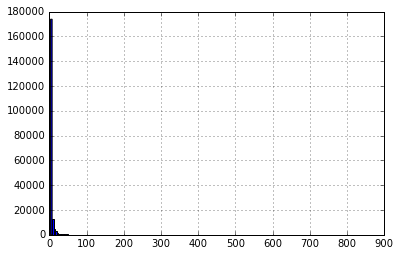

In [12]:
sf2 = remove_bots(sf)

In [ ]:
tr = pd.Series(sf['user_id'])
podcasts = tr.value_counts()
podcasts.hist(bins=200, title="main")

In [ ]:
fig = plt.figure()
plt.hist(podcasts, bins=200)
plt.title("Twitter Followers")
plt.xlim(0,100)
plt.xlabel("Podcasts")
plt.ylabel("Users")
plt.show()

In [ ]:
py.iplot_mpl(fig, strip_style = True, filename='data/TwitterFollowers')

In [ ]:
y = pd.Series(item_sim_mat['user_id']).value_counts()

In [11]:
def remove_bots(sf, flag=True):
    tr = pd.Series(sf['user_id'])
    podcasts = tr.value_counts()
    if flag is True:
        podcasts.hist(bins=200)
    users_following100_lessPods = gl.SArray(podcasts.index[ podcasts <= 100].values)
    return sf.filter_by(users_following100_lessPods, 'user_id')

In [13]:
no_bots = pd.Series(sf2['user_id'])

In [14]:
no_bots = no_bots.value_counts()

In [15]:
no_bots.describe()

count    199282.000000
mean          5.328911
std           5.813819
min           3.000000
25%           3.000000
50%           4.000000
75%           5.000000
max         100.000000
dtype: float64

In [17]:
item_model = gl.item_similarity_recommender.create(train_set_2, user_id="user_id", 
                                                   item_id="Title", item_data=items, verbose=False)
item_model.evaluate_precision_recall(test_set_2, cutoffs=[1,2,3,4,5], verbose=False)

Recsys training: model = item_similarity

{'precision_recall_by_user': Columns:
 	user_id	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 602930
 
 Data:
 +---------+--------+----------------+--------+-------+
 | user_id | cutoff |   precision    | recall | count |
 +---------+--------+----------------+--------+-------+
 |  user_0 |   1    |      1.0       |  1.0   |   1   |
 |  user_0 |   2    |      0.5       |  1.0   |   1   |
 |  user_0 |   3    | 0.333333333333 |  1.0   |   1   |
 |  user_0 |   4    |      0.25      |  1.0   |   1   |
 |  user_0 |   5    |      0.2       |  1.0   |   1   |
 | user_10 |   1    |      0.0       |  0.0   |   1   |
 | user_10 |   2    |      0.0       |  0.0   |   1   |
 | user_10 |   3    |      0.0       |  0.0   |   1   |
 | user_10 |   4    |      0.0       |  0.0   |   1   |
 | user_10 |   5    |      0.2       |  1.0   |   1   |
 +---------+--------+----------------+--------+-------+
 [602930 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You ca

In [ ]:
new_cols_items_reduced_5min = df_final[ df_final['Title'].isin(sf2['Title'])]
new_cols_items_reduced_5min.shape

In [ ]:
reduced_podcast = new_cols_items_reduced_5min['Title'].unique()
check = pd.Series(sf2['Title']).unique()
len(check), len(reduced_podcast)

In [ ]:
sf3_reduced = sf2.filter_by(reduced_podcast, 'Title')

In [ ]:
(train_set_3, test_set_3) = sf3_reduced.random_split(0.8, seed=1)

In [ ]:
new_cols_items_reduced_5min = gl.SFrame(new_cols_items_reduced_5min)

### Q
    see if the recall/precision is due to podcasts not being in the data set. Reduced the podcasts to only be present in both the items and user info. 
    
### A
    made the precision worse!

In [ ]:
item_model = gl.item_similarity_recommender.create(train_set_3, user_id="user_id", 
                                                   item_id="Title", item_data=new_cols_items_reduced_5min, 
                                                   verbose=False)
item_model.evaluate_precision_recall(test_set_3, cutoffs=[1,2,3,4,5], verbose=False)

In [ ]:
item_model = gl.item_similarity_recommender.create(train_set_2, user_id="user_id", 
                                                   item_id="Title", item_data=new_cols_items_reduced[r], verbose=False)
item_model.evaluate_precision_recall(test_set_2, cutoffs=[1,2,3,4,5], verbose=False)

In [ ]:
p = [ x for x in precision]
#item_data=new_cols_items_reduced[precision]

In [ ]:
precision = precision[:-1]

In [ ]:
r = [ r for r in recall]

In [ ]:
r.extend(precision)

In [ ]:
keep = cats.columns.tolist() + p

In [ ]:
df_final_cats = pd.concat([df_final, cats],axis=1)

In [ ]:
items_reduced_with_categories = df_final_cats[ df_final_cats.Title.isin(unique_pod)]
items_reduced_with_categories = gl.SFrame(items_reduced_with_categories)

In [ ]:
item_model = gl.item_similarity_recommender.create(train_set_2, user_id="user_id", 
                                                   item_id="Title", item_data=items_reduced_with_categories[keep], verbose=False)
item_model.evaluate_precision_recall(test_set_2, cutoffs=[1,2,3,4,5], verbose=False)

In [ ]:
keep = np.array(keep)

In [ ]:
keep = keep[np.where(keep!="<null>")]